# Name: Voyage Analytics – Travel Price Prediction & Recommendation System

# Summary: 
Voyage Analytics is an end-to-end machine learning project focused on the
productionization of travel-related ML systems. The project integrates
exploratory data analysis, supervised learning for flight price prediction,
a similarity-based hotel recommendation system, MLflow for experiment
tracking, and containerized deployment using Docker. A Streamlit web
application is used to provide an interactive interface for prediction and
recommendation, demonstrating practical MLOps concepts.

# Team members: 
1] Mohammed Akdas Ansari

2] Mohammad Atif Ansari

3] Maitri Shinde

# Github-link:
# Streamlit-applink:

1] Importing all the necessary libraries :

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import mlflow
import mlflow.sklearn

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor


2] Loading the dataset given 

In [3]:
flights_df = pd.read_csv("data/flights.csv")
users_df   = pd.read_csv("data/users.csv")
hotels_df  = pd.read_csv("data/hotels.csv")

print(flights_df.shape, users_df.shape, hotels_df.shape)


(271888, 10) (1340, 5) (40552, 8)


3] Starting with the EDA to understand the data better : a] flight b]users c]hotels

A) EDA for flight dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271888 entries, 0 to 271887
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   travelCode  271888 non-null  int64  
 1   userCode    271888 non-null  int64  
 2   from        271888 non-null  object 
 3   to          271888 non-null  object 
 4   flightType  271888 non-null  object 
 5   price       271888 non-null  float64
 6   time        271888 non-null  float64
 7   distance    271888 non-null  float64
 8   agency      271888 non-null  object 
 9   date        271888 non-null  object 
dtypes: float64(3), int64(2), object(5)
memory usage: 20.7+ MB


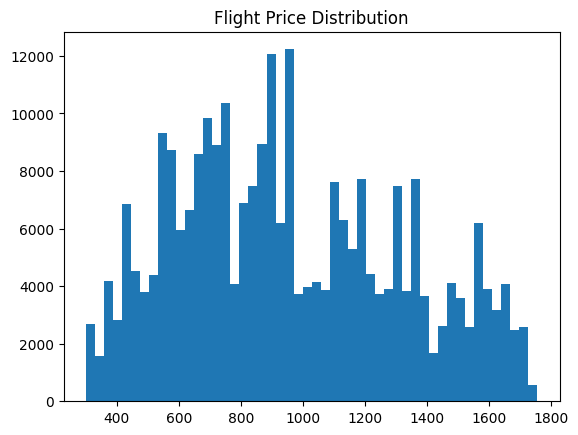

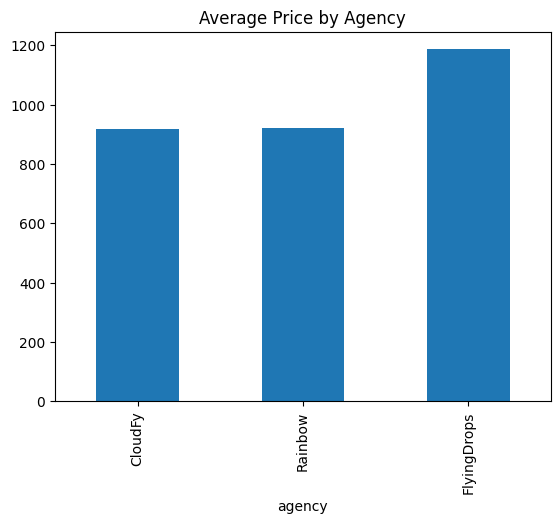

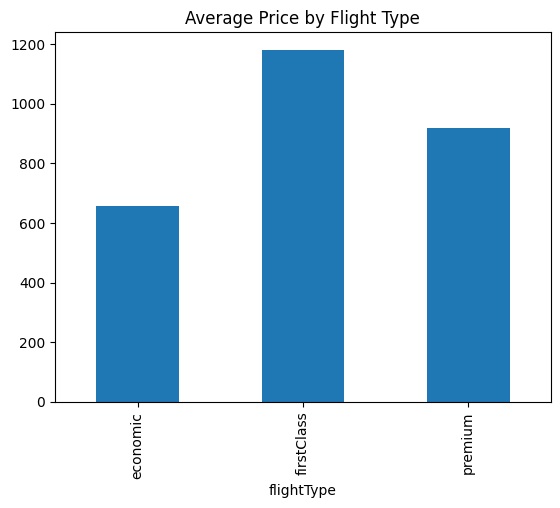

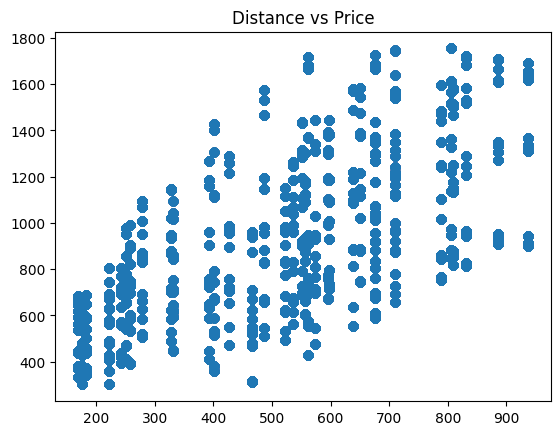

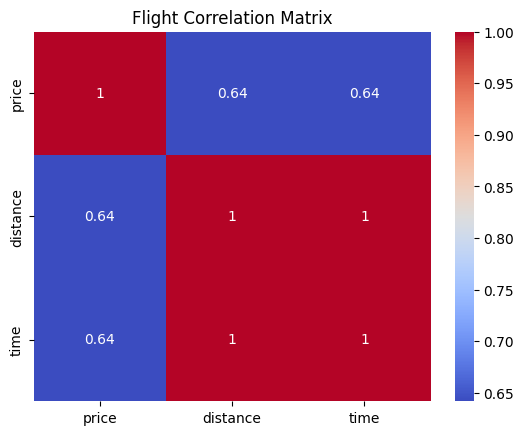

In [4]:
flights_df.info()
flights_df.describe()

plt.hist(flights_df['price'], bins=50)
plt.title("Flight Price Distribution")
plt.show()

flights_df.groupby('agency')['price'].mean().sort_values().plot(kind='bar')
plt.title("Average Price by Agency")
plt.show()

flights_df.groupby('flightType')['price'].mean().plot(kind='bar')
plt.title("Average Price by Flight Type")
plt.show()

plt.scatter(flights_df['distance'], flights_df['price'], alpha=0.5)
plt.title("Distance vs Price")
plt.show()

sns.heatmap(
    flights_df[['price','distance','time']].corr(),
    annot=True,
    cmap="coolwarm"
)
plt.title("Flight Correlation Matrix")
plt.show()


B) EDA for users dataset

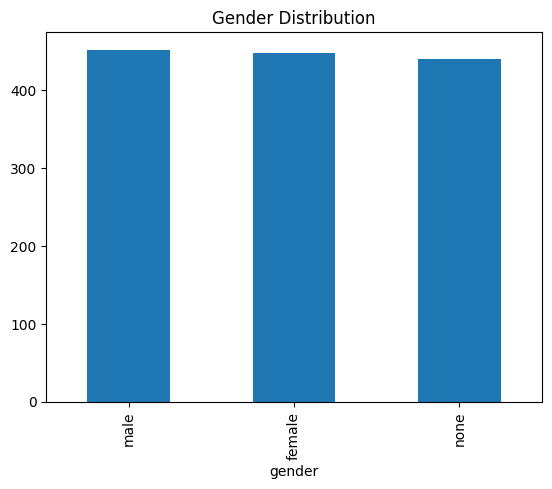

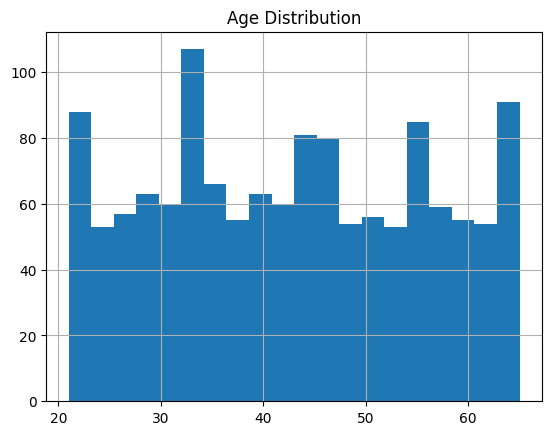

In [5]:
users_df['gender'].value_counts().plot(kind='bar')
plt.title("Gender Distribution")
plt.show()

users_df['age'].hist(bins=20)
plt.title("Age Distribution")
plt.show()


C) EDA for hotels dataset

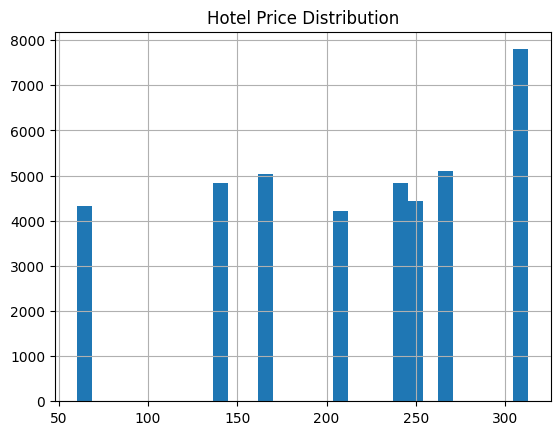

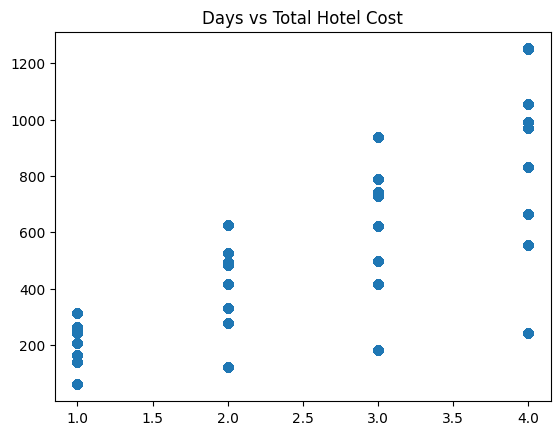

In [6]:
hotels_df['price'].hist(bins=30)
plt.title("Hotel Price Distribution")
plt.show()

plt.scatter(hotels_df['days'], hotels_df['total'], alpha=0.5)
plt.title("Days vs Total Hotel Cost")
plt.show()


4] Model Building

In [ ]:
# Features & target
X_flight = flights_df[['distance', 'time', 'agency', 'flightType', 'from', 'to']]
y_flight = flights_df['price']

# Encode categorical columns
X_flight = pd.get_dummies(X_flight, drop_first=True)

joblib.dump(X_flight.columns.tolist(), "models/flight_columns.pkl")


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_flight, y_flight, test_size=0.2, random_state=42
)

# Train model
model = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R2 Score:", r2)

# Save model
joblib.dump(model, "models/flight_price_model.pkl")

RMSE: 2.843828668524785
R2 Score: 0.9999386247980135


['models/flight_price_model.pkl']

5] Starting with ML-flow Tracking

In [ ]:
import mlflow
import mlflow.sklearn

mlflow.set_experiment("Flight Price Prediction")

with mlflow.start_run():

    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    mlflow.log_param("model", "RandomForestRegressor")
    mlflow.log_param("n_estimators", 200)
    mlflow.log_param("max_depth", 15)

    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2_score", r2)

    mlflow.sklearn.log_model(model, "flight_price_model")

    print("RMSE:", rmse)
    print("R2 Score:", r2)


2026/01/14 21:11:55 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/01/14 21:11:55 INFO mlflow.store.db.utils: Updating database tables
2026/01/14 21:11:55 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/14 21:11:55 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/01/14 21:11:55 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/14 21:11:55 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/01/14 21:12:02 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


RMSE: 2.84382866852479
R2 Score: 0.9999386247980135


In [ ]:
hotel_features = (
    hotels_df
    .groupby('name')
    .agg(
        place=('place','first'),
        avg_price=('price','mean'),
        popularity=('name','count')
    )
    .reset_index()
)


In [ ]:
hotel_preprocessor = ColumnTransformer(
    transformers=[
        ('place', OneHotEncoder(handle_unknown='ignore'), ['place']),
        ('num', StandardScaler(), ['avg_price','popularity'])
    ]
)

hotel_matrix = hotel_preprocessor.fit_transform(hotel_features)


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

similarity = cosine_similarity(hotel_matrix)

hotel_index = {
    name: idx for idx, name in enumerate(hotel_features['name'])
}

def recommend_hotels(hotel_name, top_n=5):
    if hotel_name not in hotel_index:
        return []

    idx = hotel_index[hotel_name]
    scores = similarity[idx]
    top_idx = scores.argsort()[::-1][1:top_n+1]

    return hotel_features.iloc[top_idx][['name','place','avg_price']]
